#### Fitting psychometric functions with confidence

It is useful to use more advanced statistics packages to do curve fitting so one takes advantage of optimized methods. 
Here we will use `statsmodels`; we derive from the `GenericLikelihoodModel`.

We will fit a `Weibull` and a `Cumulative gaussian` using this package.

If you just want to fit use the `fit_psychometric` function, that does the proportions and fits.



<class 'statsmodels.iolib.summary.Summary'>
"""
                          PsychometricRegression Results                          
==================================================================================
Dep. Variable:                          y   Log-Likelihood:                -559.50
Model:             PsychometricRegression   AIC:                             1127.
Method:                Maximum Likelihood   BIC:                             1147.
Date:                    Thu, 10 Aug 2023                                         
Time:                            13:27:18                                         
No. Observations:                    1158                                         
Df Residuals:                        1154                                         
Df Model:                               0                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
bias            7.5565      7.492      1.009      0.313      -7.127      22.240
sensitivity     0.0356      0.009      3.847      0.000       0.017       0.054
gamma1               0      0.093          0      1.000      -0.182       0.182
gamma2               0      0.149          0      1.000      -0.292       0.292
===============================================================================
"""

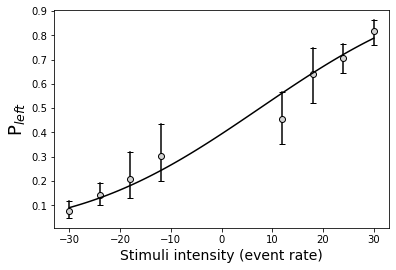

In [1]:
import numpy as np    # math and array handling 
import pandas as pd   # some functions to load data and handle tables
import pylab as plt   # plotting stuff
# import a function to compute the proportions from the behavior
import sys; sys.path.append('..')  # this is not needed if you install the module
from fit_psychometric import PsychometricRegression, fit_psychometric, cumulative_gaussian, weibull

# Note that if you want the plots to be interactive change the %matplotlib option
# the option can be 
#     qt - to use plots in a separate window,
#     notebook to use interactive "widgets" or
#     inline - not interactive
#     widget - interactive on vscode
%matplotlib inline


# load the example dataset
session_data = pd.read_hdf("../example/tutorial1_JC089_20221118.dataset.hdf5")


sel = session_data[session_data.response != 0] # select only trials where the subject responded
responded_left = np.array(sel.response == 1).astype(int) # select the response = 1 (i.e. the left side) and cast to integer datatype (number)
stim_intensities = sel.stim_intensity

res = fit_psychometric(stim_intensities.astype(float),responded_left.astype(float))

# now plot
plt.figure()
for s,c in zip(res['stims'],res['p_side_ci']):
    plt.plot(s*np.array([1,1]),c,'k-_')
plt.plot(res['stims'],res['p_side'],'ko',markerfacecolor = 'lightgray',markersize = 6)

nx = np.linspace(res['stims'].min(),res['stims'].max(),100)
plt.plot(nx,res['function'](*res['fit_params'],nx),'k')
plt.ylabel('P$_{left}$',fontsize = 18)  # set the y-axis label with latex nomenclature
plt.xlabel('Stimuli intensity (event rate)', fontsize = 14); # set the x-axis label
res['fit'].summary()


Now lets explore how we can fit using the `PsychometricRegression` object

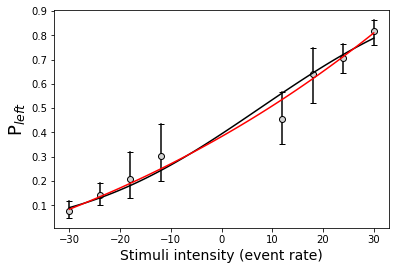

In [10]:
#The default is the cumulative gaussian, lets fit with a weibull

fit_function = weibull
bounds = [(np.min(stim_intensities),np.max(stim_intensities)),
                           (0.01,1000),
                           (0,1),(0,1)]
get_start_params  = lambda x,y: [0.001,np.max(x)/2,0,0]

reg = PsychometricRegression(responded_left,stim_intensities,
                                func = fit_function,
                                bounds = bounds,
                                startpar_function = get_start_params)
reg.exog_names[:] = ['bias','slope','gamma1','gamma2']
res_weibull = reg.fit(method = 'lbfgs') # lets use a different method for fitting here


plt.figure()
for s,c in zip(res['stims'],res['p_side_ci']):
    plt.plot(s*np.array([1,1]),c,'k-_')
plt.plot(res['stims'],res['p_side'],'ko',markerfacecolor = 'lightgray',markersize = 6)

nx = np.linspace(res['stims'].min(),res['stims'].max(),100)
plt.plot(nx,res['function'](*res['fit_params'],nx),'k')

# plot the weibull fit in red
plt.plot(nx,reg.fit_function(*res_weibull.params,nx),'r')

plt.ylabel('P$_{left}$',fontsize = 18)  # set the y-axis label with latex nomenclature
plt.xlabel('Stimuli intensity (event rate)', fontsize = 14); # set the x-axis label
